In [1]:
import openmc
import openmc.deplete # will be needed for depletion analysis eventually
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Create the assembly-cell model

### Materials

In [2]:
# materials

NpO2 = openmc.Material();
NpO2.add_nuclide('Np237',1);
NpO2.add_element('O',2);
NpO2.set_density('g/cc',11.143);

Al = openmc.Material();
Al.add_element('Al',1);
Al.set_density('g/cc',2.7);


target = openmc.Material.mix_materials([NpO2,Al],[0.2,0.7],'vo',
                                      name='target'); 
target.depletable = True
# note: 10% is void so expect to get a UserWarning on this.


# materials for fuel pin
uo2 = openmc.Material(name='UO2')
uo2.add_element('U',1.0, enrichment=5.0)
uo2.add_element('O',2.0)
uo2.set_density('g/cc',10.45)
uo2.depletable = True

# cladding

# based on PNNL-15870 Rev 1. 
zirc4 = openmc.Material(name='Zirc-4')
zirc4.add_element('O',0.006790); # by default add_element in atom fraction.
zirc4.add_element('Cr',0.001741);
zirc4.add_element('Fe',0.003242);
zirc4.add_element('Zr',0.977549);
zirc4.add_element('Sn',0.010677);
zirc4.set_density('g/cc',6.56);

# gap will be modeled as a void

water = openmc.Material(name='Water')
water.set_density('g/cc',0.76);
water.add_element('H',2);
water.add_element('O',1);
water.add_s_alpha_beta('c_H_in_H2O');

graphite = openmc.Material(name='Graphite')
graphite.set_density('g/cc',1.7)
graphite.add_element('C',1)
graphite.add_s_alpha_beta('c_Graphite')




/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:1177: UserWarning: Warning: sum of fractions do not add to 1, void fraction set to 0.10000000000000009
  warnings.warn(msg)


### Geometry

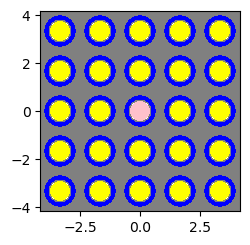

In [3]:
# create the surfaces

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

r_channel = 0.65 # cm, coolant channel radius

fuel_outer_radius = openmc.ZCylinder(r=r_fo);
clad_inner_radius = openmc.ZCylinder(r=r_ci);
clad_outer_radius = openmc.ZCylinder(r=r_co);
channel_outer_radius = openmc.ZCylinder(r=r_channel)

# define the regions

fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
coolant_region = +clad_outer_radius & -channel_outer_radius
mod_region = +channel_outer_radius

# define cells for a universe containing a fuel (UO2) pin

fuel = openmc.Cell(name='fuel');
fuel.fill = uo2;
fuel.region = fuel_region;

gap_f = openmc.Cell(name='gap_f');
gap_f.region = gap_region;
# no fill.  Makes it void by default

clad_f = openmc.Cell(name='clad_f');
clad_f.fill = zirc4;
clad_f.region = clad_region

coolant_f = openmc.Cell(name='coolant_f');
coolant_f.fill = water;
coolant_f.region = coolant_region;

mod_f = openmc.Cell(name='mod_f');
mod_f.fill = graphite;
mod_f.region = mod_region

# define the fuel pin universe

fp = openmc.Universe()
fp.add_cells([fuel,gap_f,clad_f,coolant_f,mod_f]);

# define cells for a target pin universe

fuel_t = openmc.Cell(name='fuel_t');
fuel_t.region = fuel_region;
fuel_t.fill = target

gap_t = openmc.Cell(name='gap_t');
gap_t.region = gap_region;

clad_t = openmc.Cell(name='clad_t');
clad_t.fill = zirc4
clad_t.region = clad_region;

coolant_t = openmc.Cell(name='coolant_t');
coolant_t.fill = water
coolant_t.region = coolant_region 

mod_t = openmc.Cell(name='mod_t');
mod_t.fill = graphite;
mod_t.region = mod_region

tp = openmc.Universe()
tp.add_cells([fuel_t,gap_t,clad_t,coolant_t,mod_t]);

# We also want to define an "all coolant" universe to use with the lattice we will be making.

all_coolant_cell = openmc.Cell(name='all_coolant_cell')
all_coolant_cell.fill = water
# with no region, water will just be everywhere (I think!!)

cu = openmc.Universe()
cu.add_cells([all_coolant_cell]);

# create the assembly/core geometry

P_D = 1.75     # pitch/diameter ratio
N_assy = 5; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch # cm, assembly pitch

h_assy = 100; # cm, height of the assembly model

assy_box = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_assy/2.,h_assy/2.,
                                                  boundary_type='reflective');
# other boundary types = 'periodic' and 'vacuum'

assy_lat = openmc.RectLattice()
assy_lat.center = (0.,0.)
assy_lat.dimension = [N_assy,N_assy]
assy_lat.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
assy_lat.pitch = [pitch,pitch]
assy_lat.universes=[
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, tp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp]
]
assy_lat.outer = cu; # coolant universe is outside of the assy lattice.

assy_u = openmc.Universe()
assy_cell = openmc.Cell()
assy_cell.fill = assy_lat;
assy_cell.region = -assy_box
assy_u.add_cell(assy_cell);

# define a colors dictionary so we can tell OpenMC how to color our plots
colors = {}
colors[water]='blue';
colors[uo2]='yellow';
colors[zirc4]='gray';
colors[target]='pink';
colors[graphite]='gray';

# plot the assembly universe and make sure it looks right.
assy_u.plot(width=(a_pitch,a_pitch),color_by='material',colors=colors)

In [4]:
# create the geometry and export to XML

geometry = openmc.Geometry()
geometry.root_universe = assy_u

geometry.export_to_xml()

# Add volume calculation to materials and write materials to xml

# volume calc for target:
num_tgt_pins = 1;
num_fuel_pins = 24;
target.volume = np.pi*(r_fo**2)*h_assy*num_tgt_pins
uo2.volume = np.pi*(r_fo**2)*h_assy*num_fuel_pins

materials = openmc.Materials([target, uo2, zirc4, water, graphite]);
materials.export_to_xml();

### Tallies

In [5]:
# filters for energy, cells, and reactions
cell_filter = openmc.CellFilter(fuel_t); # measure in the target material cell

cell_filter_assy = openmc.CellFilter(assy_cell);

# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# avg flux for the whole core
flux_avg = openmc.Tally(name='avg flux')
flux_avg.scores = ['flux'];
flux_avg.filters = [cell_filter_assy, energy_filter];



# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

tallies = openmc.Tallies([flux_target,flux_avg,np237_capture_t]);
tallies.export_to_xml()

In [6]:
# create settings for criticality

settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-a_pitch/2.,-a_pitch/2.,-h_assy/2.),
                      upper_right=(a_pitch/2.,a_pitch/2.,h_assy/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

## Conduct Depletion Calculation

In [7]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,"chain_casl_pwr.xml");

# Typical PWR power_density = 30.5 W/gHM
power_density = 30.5; # W/gHM
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days];

cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()



                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd108.h5
 Reading Ag107 from /home/sblair/OMC_DATA/

 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5


          1200K
          2500K


 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

      109/1    1.26717    1.28501 +/- 0.00140
      110/1    1.30941    1.28542 +/- 0.00144
      111/1    1.27616    1.28527 +/- 0.00142
      112/1    1.27301    1.28507 +/- 0.00141
      113/1    1.27802    1.28496 +/- 0.00139
      114/1    1.29081    1.28505 +/- 0.00137
      115/1    1.30336    1.28533 +/- 0.00138
      116/1    1.28446    1.28532 +/- 0.00136
      117/1    1.27169    1.28511 +/- 0.00136
      118/1    1.28242    1.28507 +/- 0.00134
      119/1    1.27764    1.28497 +/- 0.00132
      120/1    1.29425    1.28510 +/- 0.00131
      121/1    1.26506    1.28482 +/- 0.00132
      122/1    1.28277    1.28479 +/- 0.00130
      123/1    1.27624    1.28467 +/- 0.00129
      124/1    1.29008    1.28474 +/- 0.00127
      125/1    1.28922    1.28480 +/- 0.00126
      126/1    1.28230    1.28477 +/- 0.00124
      127/1    1.27987    1.28471 +/- 0.00123
      128/1    1.29047    1.28478 +/- 0.00121
      129/1    1.26345    1.28451 +/- 0.00123
      130/1    1.28312    1.28449 

       78/1    1.28611    1.27948 +/- 0.00278
       79/1    1.28610    1.27971 +/- 0.00269
       80/1    1.27126    1.27943 +/- 0.00261
       81/1    1.29066    1.27979 +/- 0.00255
       82/1    1.25271    1.27895 +/- 0.00261
       83/1    1.28462    1.27912 +/- 0.00254
       84/1    1.29957    1.27972 +/- 0.00254
       85/1    1.28347    1.27983 +/- 0.00246
       86/1    1.28006    1.27983 +/- 0.00239
       87/1    1.27668    1.27975 +/- 0.00233
       88/1    1.29424    1.28013 +/- 0.00230
       89/1    1.26927    1.27985 +/- 0.00226
       90/1    1.28671    1.28002 +/- 0.00221
       91/1    1.29438    1.28037 +/- 0.00218
       92/1    1.26392    1.27998 +/- 0.00216
       93/1    1.28191    1.28003 +/- 0.00211
       94/1    1.25552    1.27947 +/- 0.00214
       95/1    1.26854    1.27923 +/- 0.00210
       96/1    1.29276    1.27952 +/- 0.00208
       97/1    1.29514    1.27985 +/- 0.00206
       98/1    1.27369    1.27972 +/- 0.00202
       99/1    1.26912    1.27951 

       41/1    1.28556
       42/1    1.26526
       43/1    1.27521
       44/1    1.26743
       45/1    1.26566
       46/1    1.28615
       47/1    1.26696
       48/1    1.26464
       49/1    1.26698
       50/1    1.28271
       51/1    1.27464
       52/1    1.25757    1.26611 +/- 0.00853
       53/1    1.27133    1.26785 +/- 0.00523
       54/1    1.28088    1.27110 +/- 0.00493
       55/1    1.27330    1.27154 +/- 0.00384
       56/1    1.27804    1.27263 +/- 0.00332
       57/1    1.27969    1.27363 +/- 0.00298
       58/1    1.26312    1.27232 +/- 0.00290
       59/1    1.28328    1.27354 +/- 0.00283
       60/1    1.25874    1.27206 +/- 0.00293
       61/1    1.29332    1.27399 +/- 0.00328
       62/1    1.26546    1.27328 +/- 0.00308
       63/1    1.28631    1.27428 +/- 0.00300
       64/1    1.28105    1.27477 +/- 0.00282
       65/1    1.28012    1.27512 +/- 0.00265
       66/1    1.27142    1.27489 +/- 0.00249
       67/1    1.28210    1.27532 +/- 0.00238
       68/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.27598
        2/1    1.27675
        3/1    1.27157
        4/1    1.26674
        5/1    1.23597
        6/1    1.27894
        7/1    1.27581
        8/1    1.27587
        9/1    1.26236
       10/1    1.25251
       11/1    1.24924
       12/1    1.28710
       13/1    1.27869
       14/1    1.27404
       15/1    1.28262
       16/1    1.29316
       17/1    1.25105
       18/1    1.27989
       19/1    1.27977
       20/1    1.26456
       21/1    1.29234
       22/1    1.27884
       23/1    1.26193
       24/1    1.27765
       25/1    1.26271
       26/1    1.27578
       27/1    1.26390
       28/1    1.25740
       29/1    1.27857
       30/1    1.25346
       31/1    1.25231
       32/1    1.28224
       3

      200/1    1.25703    1.27218 +/- 0.00089
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.2696e+02 seconds
   Time in transport only          = 3.2594e+02 seconds
   Time in inactive batches        = 5.5757e+01 seconds
   Time in active batches          = 2.7120e+02 seconds
   Time synchronizing fission bank = 4.5307e-01 seconds
     Sampling source sites         = 4.0269e-01 seconds
     SEND/RECV source sites        = 4.9127e-02 seconds
   Time accumulating tallies       = 3.1400e-01 seconds
   Time writing statepoints        = 1.5119e-02 seconds
 Total time for finalization       = 3.1534e-03 seconds
 Total time elapsed                = 3.2722e+02 seconds
 Calculation Rate (inactive)       = 17935.1 particles/second
 Calculation Rate (active)         = 11061

      169/1    1.24657    1.26613 +/- 0.00107
      170/1    1.27356    1.26620 +/- 0.00106
      171/1    1.27554    1.26627 +/- 0.00105
      172/1    1.23926    1.26605 +/- 0.00107
      173/1    1.25195    1.26594 +/- 0.00107
      174/1    1.26209    1.26591 +/- 0.00106
      175/1    1.27641    1.26599 +/- 0.00105
      176/1    1.27255    1.26604 +/- 0.00105
      177/1    1.26623    1.26604 +/- 0.00104
      178/1    1.26496    1.26604 +/- 0.00103
      179/1    1.26337    1.26601 +/- 0.00102
      180/1    1.27151    1.26606 +/- 0.00102
      181/1    1.27892    1.26616 +/- 0.00101
      182/1    1.25986    1.26611 +/- 0.00101
      183/1    1.23909    1.26590 +/- 0.00102
      184/1    1.25300    1.26581 +/- 0.00102
      185/1    1.25925    1.26576 +/- 0.00101
      186/1    1.26156    1.26573 +/- 0.00100
      187/1    1.27639    1.26581 +/- 0.00100
      188/1    1.26936    1.26583 +/- 0.00099
      189/1    1.28568    1.26597 +/- 0.00099
      190/1    1.26350    1.26596 

      138/1    1.25651    1.26421 +/- 0.00116
      139/1    1.27463    1.26433 +/- 0.00115
      140/1    1.28505    1.26456 +/- 0.00116
      141/1    1.28736    1.26481 +/- 0.00118
      142/1    1.25855    1.26474 +/- 0.00117
      143/1    1.26285    1.26472 +/- 0.00116
      144/1    1.26316    1.26470 +/- 0.00114
      145/1    1.27638    1.26483 +/- 0.00114
      146/1    1.25875    1.26476 +/- 0.00113
      147/1    1.23770    1.26449 +/- 0.00115
      148/1    1.25177    1.26436 +/- 0.00115
      149/1    1.26537    1.26437 +/- 0.00113
      150/1    1.22774    1.26400 +/- 0.00118
      151/1    1.26257    1.26399 +/- 0.00117
      152/1    1.24574    1.26381 +/- 0.00117
      153/1    1.27430    1.26391 +/- 0.00116
      154/1    1.26042    1.26388 +/- 0.00115
      155/1    1.25735    1.26381 +/- 0.00114
      156/1    1.24617    1.26365 +/- 0.00115
      157/1    1.26690    1.26368 +/- 0.00114
      158/1    1.27219    1.26376 +/- 0.00113
      159/1    1.25356    1.26366 

      107/1    1.25329    1.25960 +/- 0.00177
      108/1    1.25956    1.25960 +/- 0.00174
      109/1    1.25715    1.25955 +/- 0.00171
      110/1    1.26870    1.25971 +/- 0.00169
      111/1    1.26659    1.25982 +/- 0.00167
      112/1    1.26007    1.25982 +/- 0.00164
      113/1    1.24402    1.25957 +/- 0.00163
      114/1    1.25596    1.25952 +/- 0.00161
      115/1    1.22637    1.25901 +/- 0.00166
      116/1    1.26318    1.25907 +/- 0.00164
      117/1    1.24388    1.25884 +/- 0.00163
      118/1    1.26386    1.25892 +/- 0.00161
      119/1    1.25995    1.25893 +/- 0.00158
      120/1    1.24347    1.25871 +/- 0.00158
      121/1    1.25643    1.25868 +/- 0.00155
      122/1    1.27015    1.25884 +/- 0.00154
      123/1    1.26631    1.25894 +/- 0.00152
      124/1    1.26620    1.25904 +/- 0.00151
      125/1    1.26979    1.25918 +/- 0.00149
      126/1    1.24681    1.25902 +/- 0.00148
      127/1    1.24859    1.25888 +/- 0.00147
      128/1    1.26926    1.25902 

       76/1    1.26065    1.25712 +/- 0.00257
       77/1    1.24318    1.25660 +/- 0.00253
       78/1    1.25191    1.25643 +/- 0.00244
       79/1    1.26697    1.25680 +/- 0.00238
       80/1    1.27765    1.25749 +/- 0.00240
       81/1    1.24553    1.25711 +/- 0.00236
       82/1    1.24927    1.25686 +/- 0.00229
       83/1    1.26535    1.25712 +/- 0.00224
       84/1    1.24171    1.25667 +/- 0.00222
       85/1    1.25439    1.25660 +/- 0.00216
       86/1    1.25163    1.25646 +/- 0.00210
       87/1    1.25524    1.25643 +/- 0.00204
       88/1    1.26550    1.25667 +/- 0.00200
       89/1    1.23945    1.25623 +/- 0.00200
       90/1    1.24679    1.25599 +/- 0.00196
       91/1    1.25932    1.25607 +/- 0.00192
       92/1    1.24558    1.25582 +/- 0.00189
       93/1    1.26744    1.25609 +/- 0.00186
       94/1    1.25959    1.25617 +/- 0.00182
       95/1    1.26798    1.25643 +/- 0.00180
       96/1    1.25522    1.25641 +/- 0.00176
       97/1    1.24126    1.25609 

       37/1    1.25220
       38/1    1.25506
       39/1    1.25198
       40/1    1.24965
       41/1    1.24733
       42/1    1.27981
       43/1    1.24654
       44/1    1.24644
       45/1    1.26384
       46/1    1.26295
       47/1    1.26188
       48/1    1.26768
       49/1    1.24719
       50/1    1.26259
       51/1    1.23964
       52/1    1.26482    1.25223 +/- 0.01259
       53/1    1.26318    1.25588 +/- 0.00813
       54/1    1.24286    1.25262 +/- 0.00661
       55/1    1.25088    1.25227 +/- 0.00513
       56/1    1.26807    1.25491 +/- 0.00495
       57/1    1.26679    1.25660 +/- 0.00451
       58/1    1.24868    1.25561 +/- 0.00403
       59/1    1.23825    1.25368 +/- 0.00405
       60/1    1.24183    1.25250 +/- 0.00381
       61/1    1.26189    1.25335 +/- 0.00355
       62/1    1.25988    1.25390 +/- 0.00328
       63/1    1.26001    1.25437 +/- 0.00306
       64/1    1.26088    1.25483 +/- 0.00287
       65/1    1.25295    1.25471 +/- 0.00267
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.25036
        2/1    1.23231
        3/1    1.25121
        4/1    1.23684
        5/1    1.24991
        6/1    1.26914
        7/1    1.26095
        8/1    1.26401
        9/1    1.24967
       10/1    1.25913
       11/1    1.25201
       12/1    1.26807
       13/1    1.24914
       14/1    1.25504
       15/1    1.23999
       16/1    1.23794
       17/1    1.26029
       18/1    1.23161
       19/1    1.24710
       20/1    1.23913
       21/1    1.25286
       22/1    1.24704
       23/1    1.25055
       24/1    1.28217
       25/1    1.25040
       26/1    1.25527
       27/1    1.26540
       28/1    1.25450
       29/1    1.24292
       30/1    1.24736
       31/1    1.25214
       32/1    1.24258
       3

      200/1    1.27314    1.25197 +/- 0.00095
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.2959e+02 seconds
   Time in transport only          = 3.2862e+02 seconds
   Time in inactive batches        = 5.6403e+01 seconds
   Time in active batches          = 2.7319e+02 seconds
   Time synchronizing fission bank = 4.5081e-01 seconds
     Sampling source sites         = 3.9962e-01 seconds
     SEND/RECV source sites        = 4.9960e-02 seconds
   Time accumulating tallies       = 2.6906e-01 seconds
   Time writing statepoints        = 2.4267e-02 seconds
 Total time for finalization       = 3.9344e-03 seconds
 Total time elapsed                = 3.2986e+02 seconds
 Calculation Rate (inactive)       = 17729.5 particles/second
 Calculation Rate (active)         = 10981

      169/1    1.24297    1.25140 +/- 0.00088
      170/1    1.24012    1.25131 +/- 0.00087
      171/1    1.25810    1.25136 +/- 0.00087
      172/1    1.25088    1.25136 +/- 0.00086
      173/1    1.24988    1.25135 +/- 0.00085
      174/1    1.24870    1.25133 +/- 0.00085
      175/1    1.23944    1.25123 +/- 0.00085
      176/1    1.25591    1.25127 +/- 0.00084
      177/1    1.24949    1.25125 +/- 0.00083
      178/1    1.24295    1.25119 +/- 0.00083
      179/1    1.26300    1.25128 +/- 0.00083
      180/1    1.24444    1.25123 +/- 0.00082
      181/1    1.23549    1.25111 +/- 0.00083
      182/1    1.24221    1.25104 +/- 0.00082
      183/1    1.26406    1.25114 +/- 0.00082
      184/1    1.22967    1.25098 +/- 0.00083
      185/1    1.26338    1.25107 +/- 0.00083
      186/1    1.25773    1.25112 +/- 0.00083
      187/1    1.24928    1.25111 +/- 0.00082
      188/1    1.24866    1.25109 +/- 0.00081
      189/1    1.25038    1.25108 +/- 0.00081
      190/1    1.25015    1.25108 

      138/1    1.23919    1.25019 +/- 0.00131
      139/1    1.23981    1.25007 +/- 0.00130
      140/1    1.25669    1.25014 +/- 0.00129
      141/1    1.25530    1.25020 +/- 0.00127
      142/1    1.27024    1.25042 +/- 0.00128
      143/1    1.25588    1.25048 +/- 0.00127
      144/1    1.24117    1.25038 +/- 0.00126
      145/1    1.26497    1.25053 +/- 0.00125
      146/1    1.22775    1.25029 +/- 0.00126
      147/1    1.24830    1.25027 +/- 0.00125
      148/1    1.23051    1.25007 +/- 0.00125
      149/1    1.25546    1.25013 +/- 0.00124
      150/1    1.24060    1.25003 +/- 0.00123
      151/1    1.27091    1.25024 +/- 0.00124
      152/1    1.23698    1.25011 +/- 0.00123
      153/1    1.25656    1.25017 +/- 0.00122
      154/1    1.25491    1.25022 +/- 0.00121
      155/1    1.23842    1.25010 +/- 0.00120
      156/1    1.24508    1.25006 +/- 0.00119
      157/1    1.25033    1.25006 +/- 0.00118
      158/1    1.26176    1.25017 +/- 0.00118
      159/1    1.23309    1.25001 

      107/1    1.24938    1.24666 +/- 0.00153
      108/1    1.25591    1.24682 +/- 0.00151
      109/1    1.23895    1.24668 +/- 0.00149
      110/1    1.24183    1.24660 +/- 0.00146
      111/1    1.24097    1.24651 +/- 0.00144
      112/1    1.25267    1.24661 +/- 0.00142
      113/1    1.24903    1.24665 +/- 0.00140
      114/1    1.24861    1.24668 +/- 0.00138
      115/1    1.25352    1.24678 +/- 0.00136
      116/1    1.24697    1.24679 +/- 0.00134
      117/1    1.25864    1.24696 +/- 0.00133
      118/1    1.25759    1.24712 +/- 0.00132
      119/1    1.25882    1.24729 +/- 0.00131
      120/1    1.24700    1.24728 +/- 0.00130
      121/1    1.23894    1.24717 +/- 0.00128
      122/1    1.24539    1.24714 +/- 0.00126
      123/1    1.24962    1.24718 +/- 0.00125
      124/1    1.24597    1.24716 +/- 0.00123
      125/1    1.26950    1.24746 +/- 0.00125
      126/1    1.24635    1.24744 +/- 0.00123
      127/1    1.25332    1.24752 +/- 0.00122
      128/1    1.24274    1.24746 

       76/1    1.24101    1.24759 +/- 0.00246
       77/1    1.25488    1.24786 +/- 0.00238
       78/1    1.23684    1.24747 +/- 0.00233
       79/1    1.26430    1.24805 +/- 0.00232
       80/1    1.24638    1.24799 +/- 0.00224
       81/1    1.25383    1.24818 +/- 0.00218
       82/1    1.24217    1.24799 +/- 0.00212
       83/1    1.24368    1.24786 +/- 0.00206
       84/1    1.24485    1.24777 +/- 0.00200
       85/1    1.24209    1.24761 +/- 0.00195
       86/1    1.24471    1.24753 +/- 0.00189
       87/1    1.23136    1.24709 +/- 0.00189
       88/1    1.23742    1.24684 +/- 0.00186
       89/1    1.25423    1.24703 +/- 0.00182
       90/1    1.23297    1.24668 +/- 0.00181
       91/1    1.23370    1.24636 +/- 0.00179
       92/1    1.25887    1.24666 +/- 0.00178
       93/1    1.25132    1.24677 +/- 0.00174
       94/1    1.24455    1.24672 +/- 0.00170
       95/1    1.24546    1.24669 +/- 0.00166
       96/1    1.25641    1.24690 +/- 0.00164
       97/1    1.25539    1.24708 

       37/1    1.24967
       38/1    1.24232
       39/1    1.23322
       40/1    1.25132
       41/1    1.25104
       42/1    1.24558
       43/1    1.25330
       44/1    1.24165
       45/1    1.23059
       46/1    1.25003
       47/1    1.24078
       48/1    1.23847
       49/1    1.23942
       50/1    1.24859
       51/1    1.25038
       52/1    1.23224    1.24131 +/- 0.00907
       53/1    1.24292    1.24185 +/- 0.00527
       54/1    1.26780    1.24834 +/- 0.00748
       55/1    1.24810    1.24829 +/- 0.00580
       56/1    1.27221    1.25228 +/- 0.00619
       57/1    1.24453    1.25117 +/- 0.00535
       58/1    1.25736    1.25194 +/- 0.00469
       59/1    1.26771    1.25370 +/- 0.00449
       60/1    1.25365    1.25369 +/- 0.00402
       61/1    1.24404    1.25281 +/- 0.00374
       62/1    1.24332    1.25202 +/- 0.00351
       63/1    1.25186    1.25201 +/- 0.00322
       64/1    1.25126    1.25196 +/- 0.00299
       65/1    1.23930    1.25111 +/- 0.00290
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.23772
        2/1    1.24787
        3/1    1.25916
        4/1    1.26508
        5/1    1.24951
        6/1    1.24456
        7/1    1.23707
        8/1    1.25432
        9/1    1.22201
       10/1    1.25837
       11/1    1.23797
       12/1    1.26126
       13/1    1.24422
       14/1    1.26765
       15/1    1.26660
       16/1    1.23938
       17/1    1.24643
       18/1    1.23382
       19/1    1.25333
       20/1    1.24880
       21/1    1.24283
       22/1    1.23986
       23/1    1.25052
       24/1    1.23205
       25/1    1.25727
       26/1    1.24119
       27/1    1.25094
       28/1    1.25954
       29/1    1.24416
       30/1    1.25035
       31/1    1.25123
       32/1    1.25757
       3

      200/1    1.24329    1.24617 +/- 0.00089
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.3186e+02 seconds
   Time in transport only          = 3.3081e+02 seconds
   Time in inactive batches        = 5.7334e+01 seconds
   Time in active batches          = 2.7453e+02 seconds
   Time synchronizing fission bank = 4.5692e-01 seconds
     Sampling source sites         = 4.0496e-01 seconds
     SEND/RECV source sites        = 5.0694e-02 seconds
   Time accumulating tallies       = 3.3965e-01 seconds
   Time writing statepoints        = 2.1323e-02 seconds
 Total time for finalization       = 3.2135e-03 seconds
 Total time elapsed                = 3.3213e+02 seconds
 Calculation Rate (inactive)       = 17441.5 particles/second
 Calculation Rate (active)         = 10927

      169/1    1.23617    1.24582 +/- 0.00098
      170/1    1.23560    1.24573 +/- 0.00097
      171/1    1.25477    1.24581 +/- 0.00097
      172/1    1.24131    1.24577 +/- 0.00096
      173/1    1.24079    1.24573 +/- 0.00095
      174/1    1.25189    1.24578 +/- 0.00095
      175/1    1.24469    1.24577 +/- 0.00094
      176/1    1.24312    1.24575 +/- 0.00093
      177/1    1.25371    1.24581 +/- 0.00093
      178/1    1.22377    1.24564 +/- 0.00094
      179/1    1.24465    1.24563 +/- 0.00093
      180/1    1.24543    1.24563 +/- 0.00092
      181/1    1.24091    1.24560 +/- 0.00091
      182/1    1.23526    1.24552 +/- 0.00091
      183/1    1.23525    1.24544 +/- 0.00091
      184/1    1.24778    1.24546 +/- 0.00090
      185/1    1.24289    1.24544 +/- 0.00089
      186/1    1.23958    1.24540 +/- 0.00089
      187/1    1.24196    1.24537 +/- 0.00088
      188/1    1.23150    1.24527 +/- 0.00088
      189/1    1.24466    1.24527 +/- 0.00088
      190/1    1.22484    1.24512 

      138/1    1.24333    1.24546 +/- 0.00130
      139/1    1.26108    1.24564 +/- 0.00130
      140/1    1.25257    1.24571 +/- 0.00129
      141/1    1.24962    1.24576 +/- 0.00127
      142/1    1.26541    1.24597 +/- 0.00128
      143/1    1.26015    1.24612 +/- 0.00127
      144/1    1.24958    1.24616 +/- 0.00126
      145/1    1.23985    1.24609 +/- 0.00125
      146/1    1.23949    1.24602 +/- 0.00124
      147/1    1.24965    1.24606 +/- 0.00123
      148/1    1.22994    1.24590 +/- 0.00122
      149/1    1.25646    1.24600 +/- 0.00122
      150/1    1.24584    1.24600 +/- 0.00120
      151/1    1.24093    1.24595 +/- 0.00119
      152/1    1.23823    1.24588 +/- 0.00118
      153/1    1.23693    1.24579 +/- 0.00118
      154/1    1.24958    1.24583 +/- 0.00117
      155/1    1.24786    1.24584 +/- 0.00115
      156/1    1.23482    1.24574 +/- 0.00115
      157/1    1.26227    1.24590 +/- 0.00115
      158/1    1.22461    1.24570 +/- 0.00115
      159/1    1.25777    1.24581 

      107/1    1.23306    1.24517 +/- 0.00140
      108/1    1.24667    1.24519 +/- 0.00137
      109/1    1.25224    1.24531 +/- 0.00136
      110/1    1.24888    1.24537 +/- 0.00133
      111/1    1.25503    1.24553 +/- 0.00132
      112/1    1.25665    1.24571 +/- 0.00131
      113/1    1.24726    1.24573 +/- 0.00129
      114/1    1.25330    1.24585 +/- 0.00128
      115/1    1.24504    1.24584 +/- 0.00126
      116/1    1.25134    1.24592 +/- 0.00124
      117/1    1.22676    1.24564 +/- 0.00125
      118/1    1.23642    1.24550 +/- 0.00124
      119/1    1.25448    1.24563 +/- 0.00123
      120/1    1.25160    1.24572 +/- 0.00122
      121/1    1.23891    1.24562 +/- 0.00120
      122/1    1.23496    1.24547 +/- 0.00120
      123/1    1.26525    1.24574 +/- 0.00121
      124/1    1.23784    1.24564 +/- 0.00120
      125/1    1.25624    1.24578 +/- 0.00119
      126/1    1.26124    1.24598 +/- 0.00119
      127/1    1.25296    1.24607 +/- 0.00118
      128/1    1.25101    1.24613 

       76/1    1.24982    1.24809 +/- 0.00165
       77/1    1.25205    1.24824 +/- 0.00159
       78/1    1.24863    1.24825 +/- 0.00153
       79/1    1.23654    1.24785 +/- 0.00153
       80/1    1.27193    1.24865 +/- 0.00168
       81/1    1.21842    1.24768 +/- 0.00190
       82/1    1.23506    1.24728 +/- 0.00188
       83/1    1.25459    1.24750 +/- 0.00184
       84/1    1.24454    1.24742 +/- 0.00178
       85/1    1.23791    1.24715 +/- 0.00175
       86/1    1.23499    1.24681 +/- 0.00174
       87/1    1.25752    1.24710 +/- 0.00171
       88/1    1.24613    1.24707 +/- 0.00167
       89/1    1.22837    1.24659 +/- 0.00169
       90/1    1.23874    1.24640 +/- 0.00166
       91/1    1.24463    1.24635 +/- 0.00162
       92/1    1.25982    1.24667 +/- 0.00162
       93/1    1.23036    1.24629 +/- 0.00162
       94/1    1.24522    1.24627 +/- 0.00159
       95/1    1.23201    1.24595 +/- 0.00158
       96/1    1.25297    1.24611 +/- 0.00155
       97/1    1.25055    1.24620 

       37/1    1.26556
       38/1    1.25230
       39/1    1.22518
       40/1    1.26213
       41/1    1.23634
       42/1    1.25046
       43/1    1.23836
       44/1    1.24911
       45/1    1.23996
       46/1    1.23436
       47/1    1.24933
       48/1    1.24323
       49/1    1.24436
       50/1    1.23714
       51/1    1.23568
       52/1    1.23930    1.23749 +/- 0.00181
       53/1    1.23504    1.23667 +/- 0.00132
       54/1    1.22540    1.23385 +/- 0.00297
       55/1    1.23626    1.23434 +/- 0.00235
       56/1    1.26182    1.23892 +/- 0.00497
       57/1    1.22641    1.23713 +/- 0.00456
       58/1    1.23684    1.23709 +/- 0.00395
       59/1    1.24366    1.23782 +/- 0.00356
       60/1    1.22989    1.23703 +/- 0.00328
       61/1    1.23658    1.23699 +/- 0.00297
       62/1    1.24538    1.23769 +/- 0.00280
       63/1    1.24139    1.23797 +/- 0.00259
       64/1    1.26172    1.23967 +/- 0.00294
       65/1    1.24277    1.23988 +/- 0.00274
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.24600
        2/1    1.25238
        3/1    1.25414
        4/1    1.24169
        5/1    1.23981
        6/1    1.22982
        7/1    1.25147
        8/1    1.24090
        9/1    1.24176
       10/1    1.25920
       11/1    1.25336
       12/1    1.24463
       13/1    1.23698
       14/1    1.23174
       15/1    1.25717
       16/1    1.25915
       17/1    1.25202
       18/1    1.23809
       19/1    1.25541
       20/1    1.24699
       21/1    1.22327
       22/1    1.23151
       23/1    1.22163
       24/1    1.24773
       25/1    1.26521
       26/1    1.23202
       27/1    1.23934
       28/1    1.25581
       29/1    1.23310
       30/1    1.26099
       31/1    1.23606
       32/1    1.24428
       3

      200/1    1.24787    1.24541 +/- 0.00096
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.3177e+02 seconds
   Time in transport only          = 3.3057e+02 seconds
   Time in inactive batches        = 5.6795e+01 seconds
   Time in active batches          = 2.7497e+02 seconds
   Time synchronizing fission bank = 5.0841e-01 seconds
     Sampling source sites         = 4.5386e-01 seconds
     SEND/RECV source sites        = 5.3217e-02 seconds
   Time accumulating tallies       = 4.2736e-01 seconds
   Time writing statepoints        = 1.4845e-02 seconds
 Total time for finalization       = 3.1817e-03 seconds
 Total time elapsed                = 3.3204e+02 seconds
 Calculation Rate (inactive)       = 17607.3 particles/second
 Calculation Rate (active)         = 10910

      169/1    1.25712    1.24464 +/- 0.00100
      170/1    1.27444    1.24489 +/- 0.00103
      171/1    1.24948    1.24493 +/- 0.00102
      172/1    1.23785    1.24487 +/- 0.00101
      173/1    1.23661    1.24480 +/- 0.00101
      174/1    1.27260    1.24503 +/- 0.00102
      175/1    1.23201    1.24492 +/- 0.00102
      176/1    1.26176    1.24506 +/- 0.00102
      177/1    1.25142    1.24511 +/- 0.00101
      178/1    1.24499    1.24511 +/- 0.00100
      179/1    1.24312    1.24509 +/- 0.00100
      180/1    1.24507    1.24509 +/- 0.00099
      181/1    1.24135    1.24506 +/- 0.00098
      182/1    1.24636    1.24507 +/- 0.00097
      183/1    1.24210    1.24505 +/- 0.00097
      184/1    1.25706    1.24514 +/- 0.00096
      185/1    1.23863    1.24509 +/- 0.00096
      186/1    1.22909    1.24497 +/- 0.00096
      187/1    1.22605    1.24483 +/- 0.00096
      188/1    1.24712    1.24485 +/- 0.00095
      189/1    1.25358    1.24491 +/- 0.00095
      190/1    1.25039    1.24495 

      138/1    1.24545    1.24273 +/- 0.00105
      139/1    1.22697    1.24256 +/- 0.00105
      140/1    1.23061    1.24242 +/- 0.00105
      141/1    1.23776    1.24237 +/- 0.00104
      142/1    1.24590    1.24241 +/- 0.00103
      143/1    1.23743    1.24236 +/- 0.00102
      144/1    1.23953    1.24233 +/- 0.00101
      145/1    1.24293    1.24233 +/- 0.00100
      146/1    1.26420    1.24256 +/- 0.00101
      147/1    1.22984    1.24243 +/- 0.00101
      148/1    1.21205    1.24212 +/- 0.00105
      149/1    1.23148    1.24201 +/- 0.00104
      150/1    1.22632    1.24186 +/- 0.00104
      151/1    1.23505    1.24179 +/- 0.00104
      152/1    1.25758    1.24194 +/- 0.00104
      153/1    1.23774    1.24190 +/- 0.00103
      154/1    1.24726    1.24195 +/- 0.00102
      155/1    1.25213    1.24205 +/- 0.00101
      156/1    1.23265    1.24196 +/- 0.00101
      157/1    1.23874    1.24193 +/- 0.00100
      158/1    1.24163    1.24193 +/- 0.00099
      159/1    1.24198    1.24193 

      106/1    1.23872    1.23945 +/- 0.00140
      107/1    1.24743    1.23959 +/- 0.00138
      108/1    1.23806    1.23956 +/- 0.00135
      109/1    1.24276    1.23961 +/- 0.00133
      110/1    1.24580    1.23972 +/- 0.00131
      111/1    1.24461    1.23980 +/- 0.00129
      112/1    1.24460    1.23988 +/- 0.00128
      113/1    1.26840    1.24033 +/- 0.00133
      114/1    1.23857    1.24030 +/- 0.00131
      115/1    1.23502    1.24022 +/- 0.00130
      116/1    1.24560    1.24030 +/- 0.00128
      117/1    1.24223    1.24033 +/- 0.00126
      118/1    1.26041    1.24063 +/- 0.00128
      119/1    1.22820    1.24045 +/- 0.00127
      120/1    1.22498    1.24022 +/- 0.00127
      121/1    1.23598    1.24016 +/- 0.00125
      122/1    1.24321    1.24021 +/- 0.00124
      123/1    1.24132    1.24022 +/- 0.00122
      124/1    1.24918    1.24034 +/- 0.00121
      125/1    1.25368    1.24052 +/- 0.00121
      126/1    1.24786    1.24062 +/- 0.00119
      127/1    1.22604    1.24043 

       75/1    1.23511    1.24231 +/- 0.00274
       76/1    1.22176    1.24152 +/- 0.00274
       77/1    1.24888    1.24179 +/- 0.00266
       78/1    1.24067    1.24175 +/- 0.00256
       79/1    1.22400    1.24114 +/- 0.00254
       80/1    1.23384    1.24090 +/- 0.00247
       81/1    1.25749    1.24143 +/- 0.00245
       82/1    1.22539    1.24093 +/- 0.00242
       83/1    1.21214    1.24006 +/- 0.00250
       84/1    1.23866    1.24002 +/- 0.00243
       85/1    1.27104    1.24090 +/- 0.00252
       86/1    1.23856    1.24084 +/- 0.00245
       87/1    1.24271    1.24089 +/- 0.00238
       88/1    1.23223    1.24066 +/- 0.00233
       89/1    1.23364    1.24048 +/- 0.00228
       90/1    1.23015    1.24022 +/- 0.00224
       91/1    1.23139    1.24001 +/- 0.00219
       92/1    1.23820    1.23996 +/- 0.00214
       93/1    1.22793    1.23968 +/- 0.00211
       94/1    1.23718    1.23963 +/- 0.00206
       95/1    1.23983    1.23963 +/- 0.00201
       96/1    1.24128    1.23967 

       34/1    1.23703
       35/1    1.21920
       36/1    1.24904
       37/1    1.25630
       38/1    1.23615
       39/1    1.21043
       40/1    1.24958
       41/1    1.22856
       42/1    1.21487
       43/1    1.23589
       44/1    1.21533
       45/1    1.23924
       46/1    1.22966
       47/1    1.24527
       48/1    1.24937
       49/1    1.22894
       50/1    1.22582
       51/1    1.25114
       52/1    1.24216    1.24665 +/- 0.00449
       53/1    1.23936    1.24422 +/- 0.00355
       54/1    1.22505    1.23943 +/- 0.00541
       55/1    1.24364    1.24027 +/- 0.00428
       56/1    1.23621    1.23959 +/- 0.00356
       57/1    1.23838    1.23942 +/- 0.00301
       58/1    1.23331    1.23866 +/- 0.00272
       59/1    1.24296    1.23914 +/- 0.00244
       60/1    1.22977    1.23820 +/- 0.00238
       61/1    1.25545    1.23977 +/- 0.00266
       62/1    1.21566    1.23776 +/- 0.00315
       63/1    1.23564    1.23760 +/- 0.00290
       64/1    1.23042    1.23708 

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.22536
        2/1    1.23174
        3/1    1.24416
        4/1    1.21685
        5/1    1.23729
        6/1    1.22062
        7/1    1.24700
        8/1    1.22148
        9/1    1.23319
       10/1    1.23232
       11/1    1.26183
       12/1    1.24439
       13/1    1.24108
       14/1    1.23233
       15/1    1.24067
       16/1    1.26162
       17/1    1.21655
       18/1    1.23897
       19/1    1.23550
       20/1    1.22851
       21/1    1.22357
       22/1    1.22303
       23/1    1.25506
       24/1    1.21649
       25/1    1.23379
       26/1    1.22710
       27/1    1.24208
       28/1    1.22210
       29/1    1.22732
       30/1    1.24233
       31/1    1.23733
       32/1    1.25760
       3

      200/1    1.23582    1.23737 +/- 0.00082
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.3117e+02 seconds
   Time in transport only          = 3.2991e+02 seconds
   Time in inactive batches        = 5.6195e+01 seconds
   Time in active batches          = 2.7498e+02 seconds
   Time synchronizing fission bank = 4.6368e-01 seconds
     Sampling source sites         = 4.1108e-01 seconds
     SEND/RECV source sites        = 5.1343e-02 seconds
   Time accumulating tallies       = 5.5204e-01 seconds
   Time writing statepoints        = 1.4857e-02 seconds
 Total time for finalization       = 3.1645e-03 seconds
 Total time elapsed                = 3.3144e+02 seconds
 Calculation Rate (inactive)       = 17795.1 particles/second
 Calculation Rate (active)         = 10910

      169/1    1.22755    1.23816 +/- 0.00117
      170/1    1.23740    1.23816 +/- 0.00116
      171/1    1.22477    1.23805 +/- 0.00115
      172/1    1.21641    1.23787 +/- 0.00116
      173/1    1.23248    1.23783 +/- 0.00115
      174/1    1.23107    1.23777 +/- 0.00114
      175/1    1.23830    1.23778 +/- 0.00113
      176/1    1.24702    1.23785 +/- 0.00113
      177/1    1.23013    1.23779 +/- 0.00112
      178/1    1.25019    1.23788 +/- 0.00111
      179/1    1.23988    1.23790 +/- 0.00111
      180/1    1.22392    1.23779 +/- 0.00110
      181/1    1.24644    1.23786 +/- 0.00110
      182/1    1.24284    1.23790 +/- 0.00109
      183/1    1.23741    1.23789 +/- 0.00108
      184/1    1.24552    1.23795 +/- 0.00107
      185/1    1.23560    1.23793 +/- 0.00107
      186/1    1.22943    1.23787 +/- 0.00106
      187/1    1.23434    1.23784 +/- 0.00105
      188/1    1.23106    1.23779 +/- 0.00105
      189/1    1.23399    1.23777 +/- 0.00104
      190/1    1.23111    1.23772 

      138/1    1.23291    1.23517 +/- 0.00109
      139/1    1.22628    1.23507 +/- 0.00108
      140/1    1.23636    1.23508 +/- 0.00107
      141/1    1.24138    1.23515 +/- 0.00106
      142/1    1.22277    1.23502 +/- 0.00105
      143/1    1.24294    1.23510 +/- 0.00105
      144/1    1.22040    1.23495 +/- 0.00105
      145/1    1.23066    1.23490 +/- 0.00104
      146/1    1.23433    1.23490 +/- 0.00103
      147/1    1.25029    1.23506 +/- 0.00103
      148/1    1.23304    1.23503 +/- 0.00102
      149/1    1.22243    1.23491 +/- 0.00102
      150/1    1.23429    1.23490 +/- 0.00101
      151/1    1.24371    1.23499 +/- 0.00100
      152/1    1.24678    1.23510 +/- 0.00100
      153/1    1.22978    1.23505 +/- 0.00099
      154/1    1.24223    1.23512 +/- 0.00098
      155/1    1.21586    1.23494 +/- 0.00099
      156/1    1.25008    1.23508 +/- 0.00099
      157/1    1.24119    1.23514 +/- 0.00098
      158/1    1.24155    1.23520 +/- 0.00097
      159/1    1.24193    1.23526 

      107/1    1.21466    1.23409 +/- 0.00154
      108/1    1.20551    1.23360 +/- 0.00160
      109/1    1.21964    1.23336 +/- 0.00159
      110/1    1.22289    1.23319 +/- 0.00157
      111/1    1.24279    1.23335 +/- 0.00155
      112/1    1.24660    1.23356 +/- 0.00154
      113/1    1.23024    1.23351 +/- 0.00152
      114/1    1.23202    1.23349 +/- 0.00149
      115/1    1.23169    1.23346 +/- 0.00147
      116/1    1.22292    1.23330 +/- 0.00146
      117/1    1.22896    1.23323 +/- 0.00144
      118/1    1.21756    1.23300 +/- 0.00143
      119/1    1.22529    1.23289 +/- 0.00142
      120/1    1.24163    1.23302 +/- 0.00140
      121/1    1.23385    1.23303 +/- 0.00138
      122/1    1.24521    1.23320 +/- 0.00137
      123/1    1.22770    1.23312 +/- 0.00136
      124/1    1.23804    1.23319 +/- 0.00134
      125/1    1.24665    1.23337 +/- 0.00133
      126/1    1.22029    1.23320 +/- 0.00133
      127/1    1.22929    1.23314 +/- 0.00131
      128/1    1.23265    1.23314 

       76/1    1.22647    1.23281 +/- 0.00245
       77/1    1.21784    1.23225 +/- 0.00242
       78/1    1.23538    1.23236 +/- 0.00234
       79/1    1.24897    1.23294 +/- 0.00233
       80/1    1.24092    1.23320 +/- 0.00226
       81/1    1.22526    1.23295 +/- 0.00220
       82/1    1.23073    1.23288 +/- 0.00214
       83/1    1.24735    1.23332 +/- 0.00212
       84/1    1.21821    1.23287 +/- 0.00210
       85/1    1.25043    1.23337 +/- 0.00210
       86/1    1.23078    1.23330 +/- 0.00204
       87/1    1.24361    1.23358 +/- 0.00201
       88/1    1.24968    1.23400 +/- 0.00200
       89/1    1.24086    1.23418 +/- 0.00195
       90/1    1.24158    1.23436 +/- 0.00191
       91/1    1.22212    1.23407 +/- 0.00189
       92/1    1.24030    1.23421 +/- 0.00185
       93/1    1.24692    1.23451 +/- 0.00183
       94/1    1.23742    1.23458 +/- 0.00179
       95/1    1.25187    1.23496 +/- 0.00179
       96/1    1.23773    1.23502 +/- 0.00175
       97/1    1.24197    1.23517 

       37/1    1.22120
       38/1    1.24716
       39/1    1.22787
       40/1    1.22184
       41/1    1.23821
       42/1    1.21010
       43/1    1.23677
       44/1    1.22954
       45/1    1.27134
       46/1    1.23130
       47/1    1.23806
       48/1    1.22531
       49/1    1.23823
       50/1    1.23867
       51/1    1.24139
       52/1    1.23237    1.23688 +/- 0.00451
       53/1    1.23919    1.23765 +/- 0.00272
       54/1    1.23790    1.23771 +/- 0.00192
       55/1    1.22730    1.23563 +/- 0.00256
       56/1    1.23422    1.23539 +/- 0.00210
       57/1    1.22807    1.23435 +/- 0.00206
       58/1    1.22159    1.23275 +/- 0.00240
       59/1    1.24505    1.23412 +/- 0.00252
       60/1    1.24202    1.23491 +/- 0.00238
       61/1    1.25112    1.23638 +/- 0.00261
       62/1    1.24815    1.23736 +/- 0.00258
       63/1    1.23249    1.23699 +/- 0.00240
       64/1    1.22573    1.23618 +/- 0.00236
       65/1    1.23400    1.23604 +/- 0.00221
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.24511
        2/1    1.23072
        3/1    1.22647
        4/1    1.24153
        5/1    1.24920
        6/1    1.23609
        7/1    1.23447
        8/1    1.25552
        9/1    1.21970
       10/1    1.24154
       11/1    1.23202
       12/1    1.21669
       13/1    1.23696
       14/1    1.22346
       15/1    1.22791
       16/1    1.22759
       17/1    1.23746
       18/1    1.23307
       19/1    1.24771
       20/1    1.22950
       21/1    1.24184
       22/1    1.22818
       23/1    1.23121
       24/1    1.24621
       25/1    1.24378
       26/1    1.23679
       27/1    1.23663
       28/1    1.21537
       29/1    1.23992
       30/1    1.23404
       31/1    1.23188
       32/1    1.24573
       3

      200/1    1.23721    1.23242 +/- 0.00082
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.2846e+02 seconds
   Time in transport only          = 3.2736e+02 seconds
   Time in inactive batches        = 5.6036e+01 seconds
   Time in active batches          = 2.7243e+02 seconds
   Time synchronizing fission bank = 4.6394e-01 seconds
     Sampling source sites         = 4.1244e-01 seconds
     SEND/RECV source sites        = 5.0247e-02 seconds
   Time accumulating tallies       = 3.8378e-01 seconds
   Time writing statepoints        = 1.4988e-02 seconds
 Total time for finalization       = 3.1810e-03 seconds
 Total time elapsed                = 3.2873e+02 seconds
 Calculation Rate (inactive)       = 17845.7 particles/second
 Calculation Rate (active)         = 11012

      168/1    1.23263    1.23054 +/- 0.00084
      169/1    1.23177    1.23055 +/- 0.00084
      170/1    1.24812    1.23070 +/- 0.00084
      171/1    1.22916    1.23069 +/- 0.00083
      172/1    1.21353    1.23054 +/- 0.00084
      173/1    1.22974    1.23054 +/- 0.00083
      174/1    1.22262    1.23047 +/- 0.00083
      175/1    1.22479    1.23043 +/- 0.00082
      176/1    1.23250    1.23045 +/- 0.00082
      177/1    1.22095    1.23037 +/- 0.00081
      178/1    1.23306    1.23039 +/- 0.00081
      179/1    1.23590    1.23043 +/- 0.00080
      180/1    1.24052    1.23051 +/- 0.00080
      181/1    1.22149    1.23044 +/- 0.00080
      182/1    1.25275    1.23061 +/- 0.00081
      183/1    1.23217    1.23062 +/- 0.00080
      184/1    1.23696    1.23067 +/- 0.00080
      185/1    1.22915    1.23066 +/- 0.00079
      186/1    1.24724    1.23078 +/- 0.00080
      187/1    1.22823    1.23076 +/- 0.00079
      188/1    1.24616    1.23087 +/- 0.00079
      189/1    1.24055    1.23094 

      137/1    1.21839    1.23034 +/- 0.00109
      138/1    1.23017    1.23034 +/- 0.00108
      139/1    1.22557    1.23028 +/- 0.00107
      140/1    1.22035    1.23017 +/- 0.00106
      141/1    1.26503    1.23056 +/- 0.00112
      142/1    1.23027    1.23055 +/- 0.00110
      143/1    1.21236    1.23036 +/- 0.00111
      144/1    1.24107    1.23047 +/- 0.00110
      145/1    1.22519    1.23041 +/- 0.00109
      146/1    1.22073    1.23031 +/- 0.00109
      147/1    1.22986    1.23031 +/- 0.00108
      148/1    1.24842    1.23049 +/- 0.00108
      149/1    1.21414    1.23033 +/- 0.00108
      150/1    1.21997    1.23023 +/- 0.00108
      151/1    1.23781    1.23030 +/- 0.00107
      152/1    1.25617    1.23055 +/- 0.00109
      153/1    1.23669    1.23061 +/- 0.00108
      154/1    1.22810    1.23059 +/- 0.00107
      155/1    1.22620    1.23055 +/- 0.00106
      156/1    1.21976    1.23045 +/- 0.00105
      157/1    1.23028    1.23044 +/- 0.00104
      158/1    1.24136    1.23055 

      105/1    1.22770    1.22987 +/- 0.00162
      106/1    1.21691    1.22964 +/- 0.00161
      107/1    1.22282    1.22952 +/- 0.00158
      108/1    1.23094    1.22954 +/- 0.00156
      109/1    1.24687    1.22983 +/- 0.00156
      110/1    1.24317    1.23006 +/- 0.00155
      111/1    1.21873    1.22987 +/- 0.00153
      112/1    1.22767    1.22984 +/- 0.00151
      113/1    1.21684    1.22963 +/- 0.00150
      114/1    1.22337    1.22953 +/- 0.00148
      115/1    1.21949    1.22938 +/- 0.00146
      116/1    1.23535    1.22947 +/- 0.00144
      117/1    1.22622    1.22942 +/- 0.00142
      118/1    1.23194    1.22946 +/- 0.00140
      119/1    1.24354    1.22966 +/- 0.00140
      120/1    1.22908    1.22965 +/- 0.00138
      121/1    1.23708    1.22976 +/- 0.00136
      122/1    1.24589    1.22998 +/- 0.00136
      123/1    1.21737    1.22981 +/- 0.00135
      124/1    1.25281    1.23012 +/- 0.00137
      125/1    1.23719    1.23021 +/- 0.00135
      126/1    1.22707    1.23017 

       74/1    1.21212    1.23122 +/- 0.00231
       75/1    1.23272    1.23128 +/- 0.00221
       76/1    1.22492    1.23104 +/- 0.00214
       77/1    1.22499    1.23081 +/- 0.00207
       78/1    1.22684    1.23067 +/- 0.00200
       79/1    1.22692    1.23054 +/- 0.00194
       80/1    1.24317    1.23096 +/- 0.00192
       81/1    1.23658    1.23114 +/- 0.00186
       82/1    1.22624    1.23099 +/- 0.00181
       83/1    1.22780    1.23089 +/- 0.00176
       84/1    1.22289    1.23066 +/- 0.00172
       85/1    1.23289    1.23072 +/- 0.00167
       86/1    1.23773    1.23092 +/- 0.00164
       87/1    1.23407    1.23100 +/- 0.00160
       88/1    1.23183    1.23102 +/- 0.00155
       89/1    1.23655    1.23117 +/- 0.00152
       90/1    1.23692    1.23131 +/- 0.00149
       91/1    1.21728    1.23097 +/- 0.00149
       92/1    1.21906    1.23068 +/- 0.00148
       93/1    1.23964    1.23089 +/- 0.00146
       94/1    1.23659    1.23102 +/- 0.00143
       95/1    1.23007    1.23100 

       33/1    1.22235
       34/1    1.23616
       35/1    1.21952
       36/1    1.21860
       37/1    1.23833
       38/1    1.23788
       39/1    1.23604
       40/1    1.22463
       41/1    1.22471
       42/1    1.21935
       43/1    1.22589
       44/1    1.21696
       45/1    1.25132
       46/1    1.23021
       47/1    1.22892
       48/1    1.25172
       49/1    1.22192
       50/1    1.23235
       51/1    1.23443
       52/1    1.24034    1.23738 +/- 0.00295
       53/1    1.22482    1.23320 +/- 0.00452
       54/1    1.23410    1.23342 +/- 0.00320
       55/1    1.21187    1.22911 +/- 0.00497
       56/1    1.23523    1.23013 +/- 0.00419
       57/1    1.21224    1.22758 +/- 0.00437
       58/1    1.21985    1.22661 +/- 0.00390
       59/1    1.22233    1.22613 +/- 0.00347
       60/1    1.22033    1.22555 +/- 0.00316
       61/1    1.22201    1.22523 +/- 0.00288
       62/1    1.22238    1.22499 +/- 0.00264
       63/1    1.24307    1.22638 +/- 0.00280
       64/1

## Post-Process Results

In [8]:
results = openmc.deplete.Results('./depletion_results.h5')

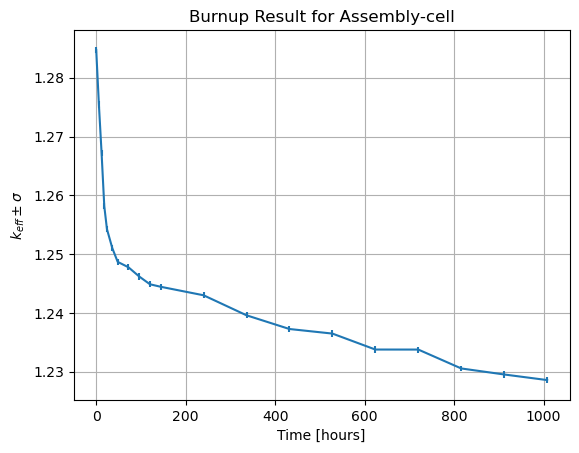

In [9]:
time, k = results.get_keff()
time /= (60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Assembly-cell')
plt.xlabel('Time [hours]')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()

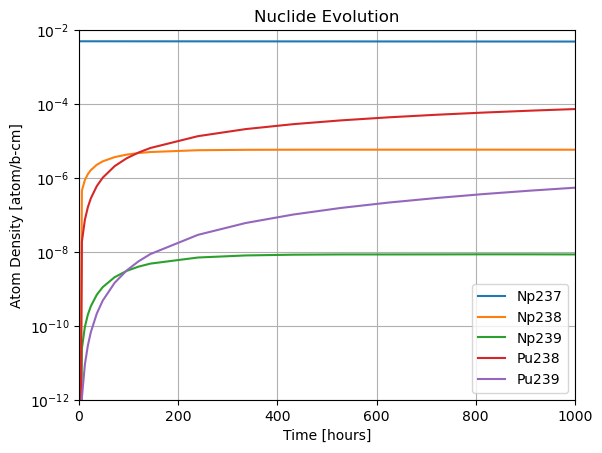

In [10]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,1000,1e-12,1e-2])
plt.legend()

### Re-do plots in relative atom density

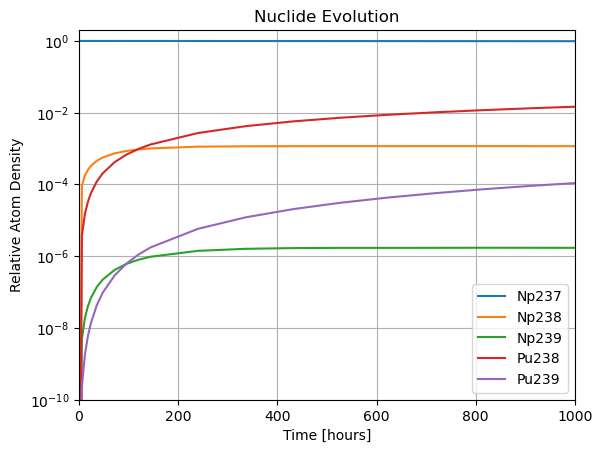

In [11]:
np237_r = np237/np237[0]
np238_r = np238/np237[0]
np239_r = np239/np237[0]
pu238_r = pu238/np237[0]
pu239_r = pu239/np237[0]

plt.semilogy(time,np237_r,label="Np237")
plt.semilogy(time,np238_r,label="Np238")
plt.semilogy(time,np239_r,label="Np239")
plt.semilogy(time,pu238_r,label="Pu238")
plt.semilogy(time,pu239_r,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Relative Atom Density")
plt.grid()
plt.axis([0,1000,1e-10,2e-0])
plt.legend()